# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [111]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from sklearn.metrics.pairwise import cosine_similarity

from torch_geometric.nn import GCNConv

In [112]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

test_set_final = pd.read_csv("../data/test_set_final.csv")
train_set_final = pd.read_csv("../data/train_set_final.csv")

## III - Data Modelling

### a) Random Baseline

In [57]:
###################
# random baseline #
###################

# Load test samples 
with open("../test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions
random_predictions = np.random.choice([0, 1], size=len(test_set))
random_pred = zip(np.array(range(len(test_set))), random_predictions)

# note: Kaggle requires that you add "ID" and "category" column headers

with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in random_pred:
         csv_out.writerow(row)
    pred.close()
    
random_predictions

array([0, 0, 1, ..., 0, 1, 1])

### b) XG Boost

In [148]:
from xgboost import XGBClassifier

from sklearn.svm import SVC

def edge_prediction(train_set, test_col, plot_roc=True):
    # Assuming 'test_col' is defined outside this function and contains the feature column names
    msk = np.random.rand(len(train_set)) < 0.8
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[test_col].values
    test_features = test_samples[test_col].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values

    # --- Build the model and train it ---
    # Here are some basic parameters, but consider tuning these for your specific problem
    clf = SVC(
        C=1,  # Regularization parameter
        kernel='poly',  # Kernel type, change this according to your needs (e.g., 'linear', 'poly', 'rbf', 'sigmoid')
        probability=True,  # Enable probability estimates (needed for ROC curve)
        random_state=42  # Ensures reproducibility
    )
    clf.fit(train_features, train_labels)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the ROC Curve from prediction scores ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    # Plotting the ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

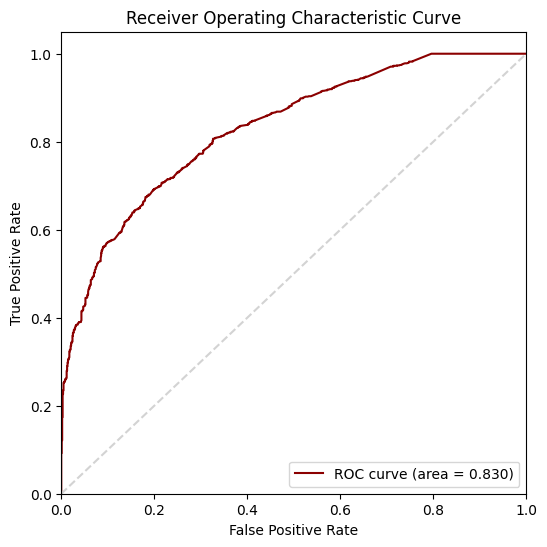

0.6587112171837709


In [149]:
test_col = ['cosine_similarity', 'source_degree', 'target_degree', 'preferential_attachment', 'shortest_path_length']
roc_auc, test_accuracy, clf = edge_prediction(train_set, test_col)

print(test_accuracy)

In [146]:
test_features = test_set[test_col].values
test_preds_values = clf.predict(test_features)
print(test_preds_values)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

[0 0 0 ... 0 0 0]


In [147]:
with open("svm_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()